A planar graph is one which can be drawn in the plane without edge crossings. Kuratowski's theorem gives a theoretical characterisation of planar graphs. However, it does not provide a practical algorithm for testing whether a graph is planar. Even though a planarity testing algorithm will tell whether a graph is planar, it might not supply a way to actually draw the graph in the plane.

Planar graphs are sparse, so graphs are specified by means of an edge list. We may assume that the vertices are labelled by integers. Note that the edge list does not identify isolated vertices but these do not affect planarity so we can assume that the number of vertices is the largest integer label. It is often convenient to have an adjacency list, which is a collection of $n$ lists, the $j$-th list giving the neighbours of vertex $j$. This can be derived from the edge list.




---

A theorem of Tutte gives a way to draw a $3$-connected planar graph $G$ in the plane. Let $C$ be a cycle with exactly one bridge. If $C$ has $k$ vertices, then place these at the corners of a convex $k$-gon. Place the remaining vertices so that each is at the centroid of its neighbours, that is, if $u$ has $d$ neighbours placed at positions $x_1, \dots, x_d$ in the plane, then $u$ has position
\begin{equation}
    x = \frac{1}{d}\sum_{i=1}^d x_i.
\end{equation}
Finding these positions requires solving a system of linear equations. Tutte proved that, under the stated conditions, there is a unique solution, and that, by adding straight line segments between adjacent vertices, we obtain a
planar drawing in which each face is a convex polygon.

In [26]:
# @title Edge Lists for Platonic Solids
platonic_data = {
    'Tetrahedron': {'outer_cycle': [1, 2, 3], 'edgelist_string': """
        1 2
        1 3
        1 4
        2 3
        2 4
        3 4
    """ }, 'Cube': {'outer_cycle': [1, 2, 3, 4], 'edgelist_string': """
        1 2
        1 4
        1 8
        2 3
        2 7
        3 4
        3 6
        4 5
        5 6
        5 8
        6 7
        7 8
    """ }, 'Octahedron': {'outer_cycle': [1, 2, 3], 'edgelist_string': """
        1 2
        1 3
        1 4
        1 5
        2 3
        3 4
        4 5
        5 2
        6 2
        6 3
        6 4
        6 5
    """ }, 'Dodecahedron': {'outer_cycle': [1, 2, 3, 4, 5], 'edgelist_string': """
        1  2
        2  3
        3  4
        4  5
        5  1
        1 12
        2 14
        3  6
        4  8
        5 10
        6  7
        7  8
        8  9
        9 10
        10 11
        11 12
        12 13
        13 14
        14 15
        15  6
        15 16
        7 17
        9 18
        11 19
        13 20
        16 17
        17 18
        18 19
        19 20
        20 16
    """ }, 'Icosahedron': {'outer_cycle': [1, 2, 3], 'edgelist_string': """
        1  2
        1  3
        1  4
        1  5
        1  6
        2  3
        3  4
        4  5
        5  6
        6  2
        2 11
        2  7
        3  7
        3  8
        4  8
        4  9
        5  9
        5 10
        6 10
        6 11
        7  8
        8  9
        9 10
        10 11
        11  7
        7 12
        8 12
        9 12
        10 12
        11 12
    """ }
}

In [27]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import io

def draw_graph(graph_object, outer_cycle_nodes, title):
    '''
    Draws a graph by placing the outer_cycle_nodes on a regular polygon
    and the rest of the nodes at the centroid of their neighbors.
    Args:
        graph_object: The NetworkX graph object to draw.
        outer_cycle_nodes: A list of nodes forming the outer cycle.
        title: The title for the plot.
    '''
    pos = {}

    # Place outer cycle nodes on a regular polygon
    k = len(outer_cycle_nodes)
    # Arrange nodes in counter-clockwise order on a unit circle
    for i, node in enumerate(outer_cycle_nodes):
        angle = 2 * np.pi * i / k
        pos[node] = (np.cos(angle), np.sin(angle))

    # Identify internal nodes
    internal_nodes = [node for node in graph_object.nodes() if node not in outer_cycle_nodes]

    if internal_nodes:
        # Set up the system of linear equations to solve for internal node positions
        n_internal = len(internal_nodes)
        node_to_idx = {node: i for i, node in enumerate(internal_nodes)}

        # The system of equations is A*x = b
        # A represents connections between internal nodes.
        # b_x and b_y represent the influence of the fixed outer nodes.
        A = np.zeros((n_internal, n_internal))
        b_x = np.zeros(n_internal)
        b_y = np.zeros(n_internal)

        for i, node in enumerate(internal_nodes):
            # The equation for each internal node u is derived from the centroid condition:
            # degree(u)*pos(u) - sum(pos(v) for v in internal_neighbors(u)) = sum(pos(w) for w in outer_neighbors(w))
            A[i, i] = graph_object.degree(node)
            for neighbor in graph_object.neighbors(node):
                if neighbor in internal_nodes:
                    j = node_to_idx[neighbor]
                    A[i, j] = -1.0
                else: # It's a fixed outer node
                    b_x[i] += pos[neighbor][0]
                    b_y[i] += pos[neighbor][1]

        # Solve the linear systems for x and y coordinates
        try:
            internal_x = np.linalg.lstsq(A, b_x, rcond=None)[0]
            internal_y = np.linalg.lstsq(A, b_y, rcond=None)[0]

            # Assign calculated positions
            for i, node in enumerate(internal_nodes):
                pos[node] = (internal_x[i], internal_y[i])
        except np.linalg.LinAlgError:
            print(f"Could not solve for positions in {title}. The matrix may be singular.")
            # Fallback: place remaining nodes at the center
            for node in internal_nodes:
                if node not in pos: pos[node] = (0, 0)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(graph_object, pos, with_labels=True)
    plt.title(title)
    plt.axis('equal') # Ensure the drawing is not stretched
    plt.show()

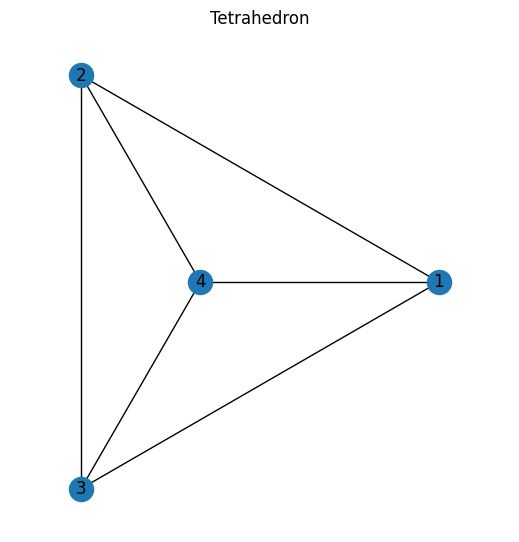

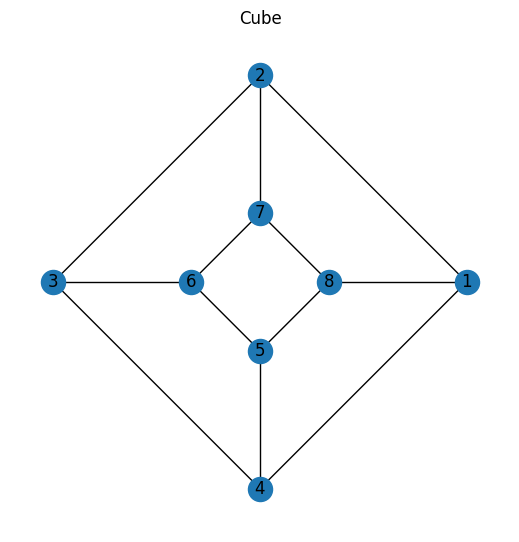

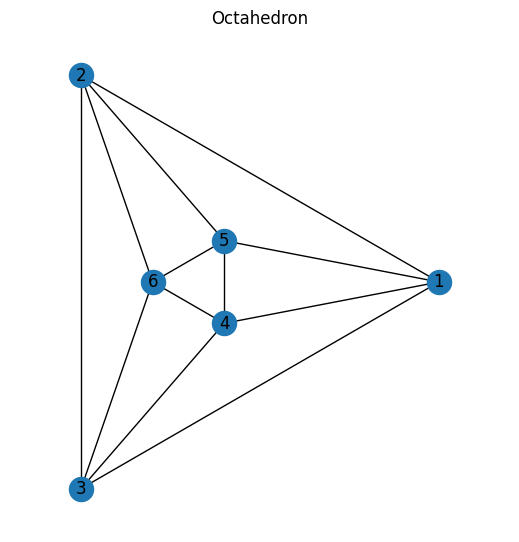

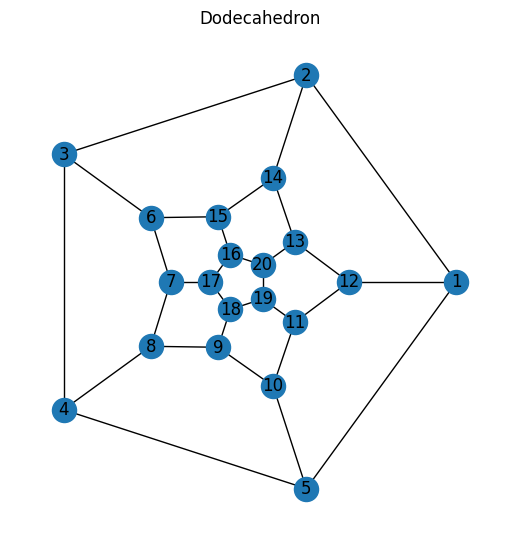

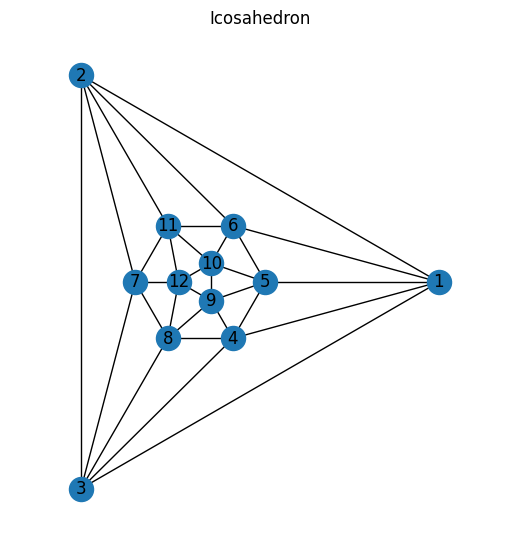

In [28]:
for name, data in platonic_data.items():
    edgelist_str = data['edgelist_string']
    s_file = io.StringIO(edgelist_str)
    G = nx.read_edgelist(s_file, nodetype=int)
    draw_graph(G, data['outer_cycle'], name)

We define the graph $K_2$ with vertex set $\{1, 2\}$ and single edge $1\text{-}2$, and the graph $P_5$ with vertex set $\{3, 4, 5, 6, 7\}$ and edge set $\{3\text{-}4, 4\text{-}5, 5\text{-}6, 6\text{-}7\}$. From these, we define the graph $K_2 + P_5$ with vertex set $\{1, 2, 3, 4, 5, 6, 7\}$, and edge set consisting of all edges of $K_2$, all edges of $P_5$, and all possible edges between a vertex of $K_2$ and a vertex of $P_5$. Thus $K_2 + P_5$ is a 'complete bipartite union' of $K_2$ and $P_5$.

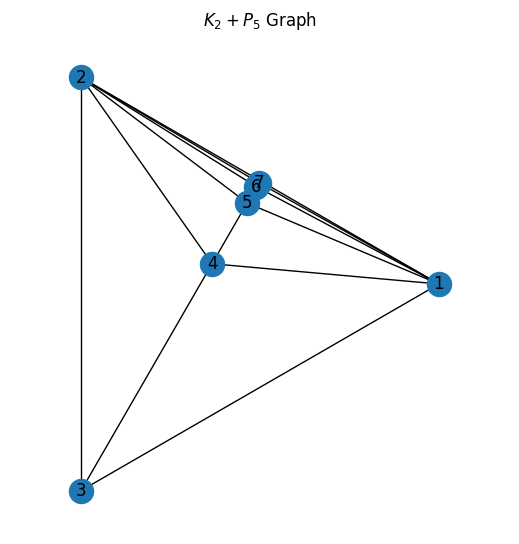

In [41]:
# Create an empty graph
G_special = nx.Graph()

# Define vertex sets
V_K2 = {1, 2}
V_P5 = {3, 4, 5, 6, 7}

# Add edges for K2 and P5
G_special.add_edge(1, 2)
nx.add_path(G_special, [3, 4, 5, 6, 7])

# Add all edges for the 'complete bipartite union'
for u in V_K2:
    for v in V_P5:
        G_special.add_edge(u, v)

# Define the outer face and draw the graph
outer_face_special = [1, 2, 3]
draw_graph(G_special, outer_face_special, f"$K_2 + P_5$ Graph")